In [1]:
import torch
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import Dataset
from accelerate import Accelerator
import logging
from sklearn.metrics import precision_recall_fscore_support
from peft import IA3Model, IA3Config

In [2]:
# Cell 2: Define the working device
device = torch.device("cuda")

In [3]:
# Cell 3: Load the model
num_class = 3
model = AutoModelForSequenceClassification.from_pretrained("/hpctmp/e0543831/GPU/InstaDeepAI", num_labels=num_class)
model = model.to(device)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at /hpctmp/e0543831/GPU/InstaDeepAI and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Cell 4: Import dataset
samples_dataframe_H = pd.read_csv("unique_sequences_H.csv", names=['sequence'])
samples_dataframe_M = pd.read_csv("unique_sequences_M.csv", names=['sequence'])
samples_dataframe_L = pd.read_csv("unique_sequences_L.csv", names=['sequence'])


In [5]:
# Cell 5: Data Preprocessing
num_random_rows = 200000
H_rand = samples_dataframe_H.sample(n=num_random_rows)
H_rand = H_rand[~H_rand['sequence'].str.contains('N')]

M_rand = samples_dataframe_M.sample(n=num_random_rows)
M_rand = M_rand[~M_rand['sequence'].str.contains('N')]

L_rand = samples_dataframe_L.sample(n=num_random_rows)
L_rand = L_rand[~L_rand['sequence'].str.contains('N')]

samples_all = pd.concat([H_rand, M_rand, L_rand])

In [6]:
# Cell 6: Creating labels for H, M, L
H_perflist_H = [0]*len(H_rand)
H_perflist_M = [1]*len(M_rand)
H_perflist_L = [2]*len(L_rand)
H_perflist = H_perflist_H + H_perflist_M + H_perflist_L

H_perflist = np.array(H_perflist)
df_temp = pd.DataFrame(H_perflist, columns=['label'], dtype='int32', index=samples_all.index)
samples_all = pd.concat([samples_all, df_temp], axis=1)

In [7]:
# Cell 7: Split the combined dataset into training, validation, and test sets
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

train_data, val_test_data = train_test_split(samples_all, test_size=val_ratio + test_ratio, random_state=42)
val_data, test_data = train_test_split(val_test_data, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)

train_sequences = train_data['sequence'].tolist()
train_labels = train_data['label'].tolist()

val_sequences = val_data['sequence'].tolist()
val_labels = val_data['label'].tolist()

test_sequences = test_data['sequence'].tolist()
test_labels = test_data['label'].tolist()

In [8]:
# In [8]:
### TOKENINIZING THE DATASET ###
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("/hpctmp/e0543831/GPU/InstaDeepAI")


In [9]:
# In [9]:
# Convert the split dataframes to Hugging Face Datasets
train_dataset = Dataset.from_dict({"data": train_sequences, 'labels': train_labels})
val_dataset = Dataset.from_dict({"data": val_sequences, 'labels': val_labels})
test_dataset = Dataset.from_dict({"data": test_sequences, 'labels': test_labels})


In [10]:
# In [10]:
def tokenize_function(examples):
    outputs = tokenizer(examples["data"])
    return outputs

# Tokenize the datasets
tokenized_train_dataset = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)

tokenized_val_dataset = val_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)

tokenized_test_dataset = test_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["data"],
)


Map:   0%|          | 0/417050 [00:00<?, ? examples/s]

Map:   0%|          | 0/59578 [00:00<?, ? examples/s]

Map:   0%|          | 0/119158 [00:00<?, ? examples/s]

In [11]:
from peft import LoraConfig, TaskType

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, inference_mode=False, r=1, lora_alpha= 32, lora_dropout=0.1, target_modules= ["query", "value"],
    #modules_to_save=["intermediate"] # modules that are not frozen and updated during the training
)

from peft import get_peft_model

lora_classifier = get_peft_model(model, peft_config) # transform our classifier into a peft model
lora_classifier.print_trainable_parameters()
lora_classifier.to(device) # Put the model on the GPU

trainable params: 1,766,403 || all params: 482,208,487 || trainable%: 0.36631520340702756


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): EsmForSequenceClassification(
      (esm): EsmModel(
        (embeddings): EsmEmbeddings(
          (word_embeddings): Embedding(4105, 1280, padding_idx=1)
          (dropout): Dropout(p=0.0, inplace=False)
          (position_embeddings): Embedding(1002, 1280, padding_idx=1)
        )
        (encoder): EsmEncoder(
          (layer): ModuleList(
            (0-23): 24 x EsmLayer(
              (attention): EsmAttention(
                (self): EsmSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=1280, out_features=1280, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1280, out_features=1, bias=False)
                    )
                    (lora_B): ModuleDict(
   

In [12]:
# In [11]:
batch_size = 32
model_name = 'NLP_' + str(num_random_rows) +'_lora_Data_MCC'
args = TrainingArguments(
    f"{model_name}-finetuned-lora-NucleotideTransformer",
    remove_unused_columns=False,
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=64,
    num_train_epochs=2,
    logging_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="mcc_score",
    label_names=["labels"],
    dataloader_drop_last=True,
    max_steps=1000
)

In [13]:
# In [12]:
"""Next, we define the metric we will use to evaluate our models and write a `compute_metrics` function. We can load this from the `scikit-learn` library."""
def compute_metrics_mcc(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=-1)
    references = eval_pred.label_ids
    r = {'mcc_score': matthews_corrcoef(references, predictions)}
    return r


In [14]:
# In [13]:
trainer = Trainer(
    lora_classifier,
    args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_mcc,
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
2024-04-05 00:11:03.908748: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 00:11:06.033378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
# In [14]:
"""We can now finetune our model by just calling the `train` method:"""
train_results = trainer.train()

print(train_results)

Step,Training Loss,Validation Loss,Mcc Score
500,1.101100,1.099560,0.007943
1000,1.097600,1.096824,0.090212


/hpctmp/e0543831/virtualenv/lib/python3.10/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /hpctmp/e0543831/GPU/InstaDeepAI - will assume that the vocabulary was not modified.
  warnings.warn(
/hpctmp/e0543831/virtualenv/lib/python3.10/site-packages/peft/utils/save_and_load.py:154: UserWarning: Could not find a config file in /hpctmp/e0543831/GPU/InstaDeepAI - will assume that the vocabulary was not modified.
  warnings.warn(


TrainOutput(global_step=1000, training_loss=1.0993876342773437, metrics={'train_runtime': 1458.5569, 'train_samples_per_second': 21.939, 'train_steps_per_second': 0.686, 'total_flos': 7854288253824000.0, 'train_loss': 1.0993876342773437, 'epoch': 0.08})


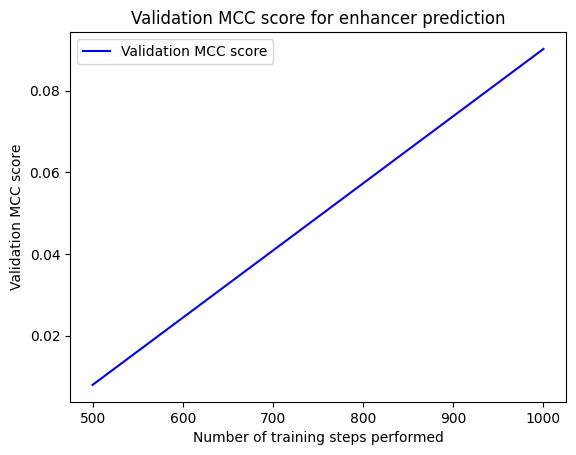

In [16]:
# In [15]:
"""As with the first task, the time can be greatly reduced by increasing the batch size.

#### **Validation MCC score**
"""

curve_evaluation_mcc_score = [[a['step'], a['eval_mcc_score']] for a in trainer.state.log_history if 'eval_mcc_score' in a.keys()]
eval_mcc_score = [c[1] for c in curve_evaluation_mcc_score]
steps = [c[0] for c in curve_evaluation_mcc_score]

plt.plot(steps, eval_mcc_score, 'b', label='Validation MCC score')
plt.title('Validation MCC score for enhancer prediction')
plt.xlabel('Number of training steps performed')
plt.ylabel('Validation MCC score')
plt.legend()
plt.show()

In [17]:
# In [16]:
# """#### **MCC on the test dataset**"""

# # Compute the MCC score on the test dataset :
print(f"MCC score on the test dataset: {trainer.predict(tokenized_test_dataset).metrics['test_mcc_score']}")


MCC score on the test dataset: 0.09022547240485528


In [18]:
# In [17]:
#### **Validation F1 score**
#curve_evaluation_f1_score =[[a['step'],a['eval_f1_score']] for a in trainer.state.log_history if 'eval_f1_score' in a.keys()]
#eval_f1_score = [c[1] for c in curve_evaluation_f1_score]
#steps = [c[0] for c in curve_evaluation_f1_score]

#plt.plot(steps, eval_f1_score, 'b', label='Validation F1 score')
#plt.title('Validation F1 score for promoter prediction')
#plt.xlabel('Number of training steps performed')
#plt.ylabel('Validation F1 score')
#plt.legend()
#plt.show()
# Compute the F1 score on the test dataset :
#print(f"F1 score on the test dataset: {trainer.predict(tokenized_test_dataset).metrics['test_f1_score']}")
     


In [19]:
# Define the directory paths to save the model and tokenizer
output_dir = 'TEST_trained_model_GPU_' + str(num_random_rows) + '_LoRA_sample_mcc_Score'
tokenizer.save_pretrained(output_dir)
model.save_pretrained(output_dir)


In [20]:
# Load the saved tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(output_dir)
model = AutoModelForSequenceClassification.from_pretrained(output_dir)

Some weights of the model checkpoint at TEST_trained_model_GPU_200000_LoRA_sample_mcc_Score were not used when initializing EsmForSequenceClassification: ['classifier.modules_to_save.default.dense.bias', 'classifier.modules_to_save.default.dense.weight', 'classifier.modules_to_save.default.out_proj.bias', 'classifier.modules_to_save.default.out_proj.weight', 'classifier.original_module.dense.bias', 'classifier.original_module.dense.weight', 'classifier.original_module.out_proj.bias', 'classifier.original_module.out_proj.weight', 'esm.encoder.layer.0.attention.self.query.base_layer.bias', 'esm.encoder.layer.0.attention.self.query.base_layer.weight', 'esm.encoder.layer.0.attention.self.query.lora_A.default.weight', 'esm.encoder.layer.0.attention.self.query.lora_B.default.weight', 'esm.encoder.layer.0.attention.self.value.base_layer.bias', 'esm.encoder.layer.0.attention.self.value.base_layer.weight', 'esm.encoder.layer.0.attention.self.value.lora_A.default.weight', 'esm.encoder.layer.0.at

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at TEST_trained_model_GPU_200000_LoRA_sample_mcc_Score and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'esm.encoder.layer.0.attention.self.query.bias', 'esm.encoder.layer.0.attention.self.query.weight', 'esm.encoder.layer.0.attention.self.value.bias', 'esm.encoder.layer.0.attention.self.value.weight', 'esm.encoder.layer.1.attention.self.query.bias', 'esm.encoder.layer.1.attention.self.query.weight', 'esm.encoder.layer.1.attention.self.value.bias', 'esm.encoder.layer.1.attention.self.value.weight', 'esm.encoder.layer.10.attention.self.query.bias', 'esm.encoder.layer.10.attention.self.query.weight', 'esm.encoder.layer.10.attention.self.value.bias', 'esm.encoder.layer.10.attention.self.value.weight', 'esm.encoder.layer.11.attention.self.query.bias', 'esm.encoder.layer.11.attention.self.query.weight', 'esm.enco

In [21]:
# Load the data, either FNS from Jingyun or Generated from Sangeetha

FNS_dataframe = pd.read_csv('FNS Sequences for ML model validation.csv')
# FNS_dataframe = pd.read_csv('Sangeetha_Seq_for_verification.csv')

# Data preprocessing: Extracting the DNA samples
FNS_dataframe = FNS_dataframe.dropna()
FNS_samples = FNS_dataframe['Sample']
FNS_samples.reset_index(drop=True, inplace=True)
FNS_sequence = FNS_dataframe['DNA Sequence']
FNS_sequence.reset_index(drop=True, inplace=True)

# Extract sequences from the DataFrame
new_sequences = FNS_sequence.tolist()

# Tokenize the new sequences
tokenized_sequences = tokenizer(new_sequences, return_tensors="pt", padding=True, truncation=True)

In [22]:
# Perform inference
model.eval()
with torch.no_grad():
    outputs = model(**tokenized_sequences)

# Get the predicted labels
predicted_labels = torch.argmax(outputs.logits, dim=1).tolist()

# Add the predicted labels to the DataFrame
FNS_dataframe['Predicted_Labels'] = predicted_labels

# Save the DataFrame with predicted labels
FNS_dataframe.to_csv(output_dir + '_FNS_Predictions.csv', index=False)

In [23]:
predict = trainer.predict(tokenized_test_dataset)
prediction = []
for i in predict[0]:
    prediction.append(np.array(i).argmax())

prediction = [int(i) for i in prediction]
y_test2 = [int(i) for i in tokenized_test_dataset['labels']]

In [24]:

# Dictionary to store counts of integers
count_dict = {}
count_dict[0] = 0
count_dict[1] = 0
count_dict[2] = 0

# Count occurrences of integers in the list
for i in y_test2:
    if i==0:
        count_dict[0] += 1
    elif i==1:
        count_dict[1] += 1
    elif i==2:
        count_dict[2] += 1

# Print the counts of integers
for num, count in count_dict.items():
    print(f"The integer {num} appears {count} time(s) in the list.")
    
n_High,n_Medium,n_Low = count_dict.values()

count_High,count_Medium,count_Low = 0,0,0

for i in range(len(prediction)):
    if prediction[i] == y_test2[i] and prediction[i] == 0:
        count_High += 1
    elif prediction[i] == y_test2[i] and prediction[i] == 1:
        count_Medium += 1
    elif prediction[i] == y_test2[i] and prediction[i] == 2:
        count_Low += 1

Correct_High = count_High/n_High * 100
Correct_Medium = count_Medium/n_Medium * 100
Correct_Low = count_Low/n_Low * 100

results_RF2 = {'Correctly Predicted-High': Correct_High,
           'Correctly Predicted-Medium': Correct_Medium, \
           'Correctly Predicted-Low':Correct_Low}
print(results_RF2)

The integer 0 appears 39738 time(s) in the list.
The integer 1 appears 39497 time(s) in the list.
The integer 2 appears 39923 time(s) in the list.
{'Correctly Predicted-High': 98.56057174492928, 'Correctly Predicted-Medium': 0.729169303997772, 'Correctly Predicted-Low': 6.129298900383238}


In [25]:
with open(output_dir + '_accuracy', 'w') as f:
    for key, value in results_RF2.items(): 
        f.write('%s:%s\n' % (key, value))
f.close()